# Метод опорных векторов (SVM)

В этом ноутбуке мы подробно разберём **метод опорных векторов** (Support Vector Machines, SVM) как классический метод для задач классификации (и кратко — регрессии).

Мы будем двигаться от интуитивных картинок к формальным определениям и коду на `scikit-learn`.

План ноутбука:

1. Пример идеально линейно разделимой выборки и простой линейной классификации.
2. Понятие отступа и геометрического зазора между классами.
3. Линейный SVM в линейно разделимом случае (hard-margin).
4. Неразделимый случай и soft-margin SVM.
5. Запись soft-margin SVM через hinge loss и $L2$-регуляризацию.
6. Линейный SVM в `scikit-learn` и влияние параметра $C$.
7. Ядровой SVM и kernel trick, RBF-ядро и параметр $\gamma$.
8. Отличия `SVC` и `LinearSVC`.
9. Опорные векторы и их роль.
10. Кратко о SVM для регрессии (SVR).
11. Практические рекомендации по применению SVM.


## 1. Идеально линейно разделимая выборка и простая линейная классификация

Начнём с очень простой ситуации: два класса в двумерном пространстве, которые **идеально** разделимы некоторой прямой.

Сгенерируем данные и обучим на них **логистическую регрессию** как пример линейного классификатора. Наша цель здесь — визуально понять, что:

- существует множество прямых, которые разделяют классы;
- метод опорных векторов выберет среди них особую — с **максимальным зазором** между классами.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, make_classification, make_circles, make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

np.random.seed(42)

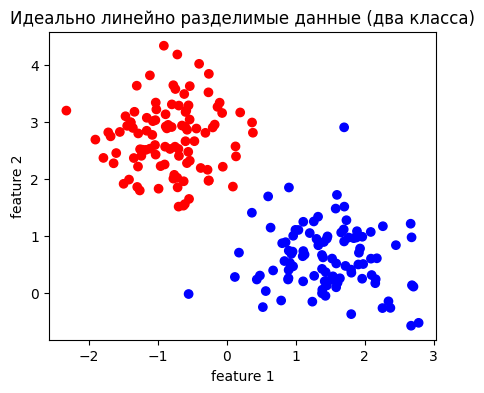

In [2]:
# Генерируем идеально линейно разделимые данные
X_sep, y_sep = make_blobs(
    n_samples=200,
    centers=2,
    cluster_std=0.6,
    center_box=(-3, 3),
    random_state=42
)

# Убеждаемся, что классы хорошо разделимы
plt.figure(figsize=(5, 4))
plt.scatter(X_sep[:, 0], X_sep[:, 1], c=y_sep, cmap=ListedColormap(["#FF0000", "#0000FF"]))
plt.title("Идеально линейно разделимые данные (два класса)")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.show()

Обучим логистическую регрессию и нарисуем разделяющую прямую. Это наш "обычный" линейный классификатор, который минимизирует логистическую потерю, но ничего не знает про максимальный зазор.


Accuracy (logreg) на всей выборке: 1.0


C:\Users\Izhan\AppData\Local\Temp\ipykernel_16200\724994040.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


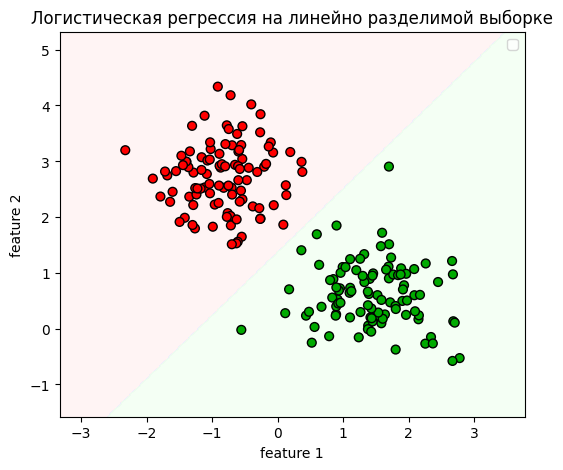

In [3]:
# Обучаем логистическую регрессию
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression())
])

logreg.fit(X_sep, y_sep)
y_pred = logreg.predict(X_sep)
print("Accuracy (logreg) на всей выборке:", accuracy_score(y_sep, y_pred))

def plot_decision_boundary(clf, X, y, title="", h=0.02, support_vectors=None):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cmap_light = ListedColormap(["#FFEEEE", "#EEEEFF", "#EEFFEE"])  # до 3 классов
    cmap_bold = ListedColormap(["#FF0000", "#0000FF", "#00AA00"])

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.6, cmap=cmap_light)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor="k", s=40)

    if support_vectors is not None:
        plt.scatter(
            support_vectors[:, 0],
            support_vectors[:, 1],
            s=120,
            facecolors="none",
            edgecolors="k",
            linewidths=1.5,
            label="support vectors"
        )

    plt.title(title)
    plt.xlabel("feature 1")
    plt.ylabel("feature 2")
    plt.legend()
    plt.show()

plot_decision_boundary(logreg, X_sep, y_sep, title="Логистическая регрессия на линейно разделимой выборке")

На картинке видно, что логистическая регрессия нашла некоторую разделяющую прямую. Но важно понимать:

- существует бесконечно много прямых, которые также идеально разделяют эти данные;
- логистическая регрессия выбирает ту, которую диктует оптимум её собственной функции потерь;
- **SVM будет выбирать прямую по другому принципу** — максимизируя зазор между классами.

Теперь сформализуем понятие зазора (margin) и увидим, как оно приводит к постановке задачи SVM.


## 2. Отступ и геометрический зазор (margin)

Рассмотрим линейный классификатор в общем виде. Пусть есть весовой вектор $w$ и сдвиг $b$, и мы классифицируем объект $x$ по знаку линейной функции

$$
f(x) = w^\top x + b.
$$

Классификатор принимает решение

$$
\hat{y}(x) = \operatorname{sign}(f(x)) = \operatorname{sign}(w^\top x + b).
$$

Для объекта $(x_i, y_i)$, где $y_i \in \{-1, 1\}$, определим **функциональный отступ** (functional margin):

$$
m_i = y_i f(x_i) = y_i (w^\top x_i + b).
$$

Интерпретация:

- если $m_i > 0$, точка классифицирована правильно;
- если $m_i < 0$, классификатор ошибается;
- чем больше $m_i$, тем "увереннее" модель классифицирует объект.


### 2.1. Почему функционального отступа недостаточно

Функциональный отступ $m_i$ зависит от масштаба вектора $w$. Если умножить $w$ и $b$ на константу $c > 0$, то значение $f(x)$ умножится на $c$, и отступ $m_i$ тоже умножится на $c$.

Но геометрически разделяющая гиперплоскость

$$
w^\top x + b = 0
$$

останется той же самой: умножение $w$ и $b$ на одну и ту же положительную константу не меняет множества точек, удовлетворяющих этому уравнению.

Поэтому **функциональный отступ нельзя напрямую использовать как геометрическую меру зазора**.


### 2.2. Геометрический зазор (geometric margin)

Нас интересует **расстояние** от точки до разделяющей гиперплоскости. Для гиперплоскости

$$
w^\top x + b = 0
$$

расстояние от точки $x$ до этой гиперплоскости равно

$$
\operatorname{dist}(x, w, b) = \frac{|w^\top x + b|}{\lVert w \rVert}.
$$

С учётом метки класса удобно ввести **геометрический отступ** (geometric margin) для точки $(x_i, y_i)$:

$$
\gamma_i = \frac{y_i (w^\top x_i + b)}{\lVert w \rVert}.
$$

Тогда:

- если $\gamma_i > 0$, точка по-прежнему классифицирована правильно;
- величина $|\gamma_i|$ — это расстояние от точки до гиперплоскости с правильным знаком.


### 2.3. Зазор для всего датасета

Для всей выборки геометрический зазор определяют как минимальный геометрический отступ по всем объектам:

$$
\gamma = \min_i \gamma_i = \min_i \frac{y_i (w^\top x_i + b)}{\lVert w \rVert}.
$$

Интуитивно:

- мы хотим, чтобы **минимальное расстояние** от точек до разделяющей гиперплоскости было как можно больше;
- метод опорных векторов строит такой линейный классификатор, который **максимизирует этот минимальный геометрический зазор** (насколько это возможно с учётом ошибок).


## 3. Линейно разделимый случай: hard-margin SVM

Теперь предположим, что данные строго линейно разделимы: существует гиперплоскость $(w, b)$, которая разделяет классы без ошибок.

Можно потребовать, чтобы для всех объектов выполнялось

$$
y_i (w^\top x_i + b) \ge 1.
$$

Это просто нормировка: мы можем всегда масштабировать $(w, b)$ так, чтобы ближайшие точки имели функциональный отступ ровно $1$.

При таком масштабировании геометрический зазор для всего датасета равен

$$
\gamma = \min_i \frac{y_i (w^\top x_i + b)}{\lVert w \rVert} = \frac{1}{\lVert w \rVert}.
$$

Отсюда видно, что **максимизация зазора** эквивалентна **минимизации нормы вектора $w$**.

Классическая постановка задачи hard-margin SVM:

$$
\min_{w, b} \; \frac{1}{2} \lVert w \rVert^2
$$

при ограничениях

$$
y_i (w^\top x_i + b) \ge 1, \quad i = 1, \dots, n.
$$

Здесь $\frac{1}{2} \lVert w \rVert^2$ играет роль регуляризационного терма, а ограничения отвечают за правильную классификацию с минимальным отступом не меньше $1$.


## 4. Неразделимый случай: soft-margin SVM и hinge loss

В реальных задачах данные почти никогда не бывают идеально линейно разделимыми. Поэтому приходится разрешать нарушения зазора и даже ошибки классификации.

Для этого вводят **переменные послаблений** $\xi_i \ge 0$ и ослабляют ограничения:

$$
y_i (w^\top x_i + b) \ge 1 - \xi_i.
$$

Если $\xi_i = 0$, объект лежит "по правильную сторону" с отступом как минимум $1$. Если $0 < \xi_i < 1$, объект по-прежнему классифицирован правильно, но отступ меньше $1$. Если $\xi_i > 1$, объект классифицирован неправильно.


### 4.1. Примальная постановка soft-margin SVM

Примальная задача soft-margin SVM записывается так:

$$
\min_{w, b, \xi} \; \frac{1}{2} \lVert w \rVert^2 + C \sum_{i=1}^n \xi_i
$$

при ограничениях

$$
y_i (w^\top x_i + b) \ge 1 - \xi_i, \quad \xi_i \ge 0.
$$

Интерпретация параметра $C > 0$:

- большой $C$ означает сильный штраф за нарушения зазора и ошибки; модель будет стремиться классифицировать как можно больше объектов правильно, даже ценой меньшего зазора;
- маленький $C$ допускает больше нарушений; зазор может быть шире, модель получается более гладкой и устойчивой, но допускает больше ошибок.


### 4.2. Запись через hinge loss и $L2$-регуляризацию

Эту задачу можно переписать через **hinge loss** (потерю-шарнир). Для одной точки определим

$$
L(\hat{y}, y) = \max(0, 1 - y \hat{y}),
$$

где $\hat{y} = f(x) = w^\top x + b$. Тогда суммарная hinge-потеря по выборке равна

$$
\sum_{i=1}^n \max(0, 1 - y_i (w^\top x_i + b)).
$$

Задача soft-margin SVM принимает вид

$$
\min_{w, b} \; \frac{1}{2} \lVert w \rVert^2 + C \sum_{i=1}^n \max(0, 1 - y_i (w^\top x_i + b)).
$$

Здесь:

- $\frac{1}{2} \lVert w \rVert^2$ — это $L2$-регуляризация на векторе весов;
- $\sum \max(0, 1 - y_i (w^\top x_i + b))$ — суммарная hinge-потеря.

Поэтому SVM удобно рассматривать как **линейный классификатор с hinge loss и $L2$-регуляризацией**, где параметр $C$ играет роль, обратную силе регуляризации (аналоги $C$ мы уже видели в логистической регрессии).


## 5. Линейный SVM в `scikit-learn` и влияние параметра $C$

Перейдём от формул к конкретной реализации. В `scikit-learn` линейный SVM для бинарной и многоклассовой классификации реализован, в частности, в классе `SVC` с `kernel="linear"`.

Посмотрим, как параметр $C$ влияет на границу и качество на линейно почти разделимой выборке.


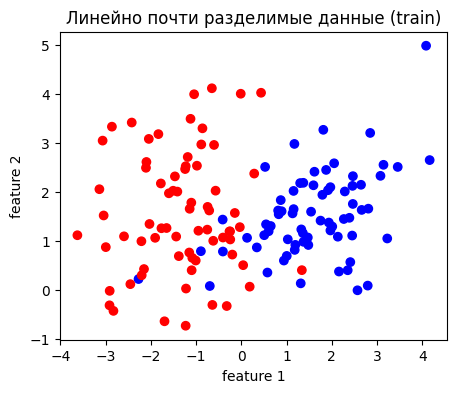

In [4]:
# Линейно почти разделимые данные (слегка сложнее, чем идеальный пример)
X_lin, y_lin = make_classification(
    n_samples=200,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    class_sep=1.5,
    flip_y=0.0,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X_lin, y_lin, test_size=0.3, random_state=42, stratify=y_lin
)

plt.figure(figsize=(5, 4))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=ListedColormap(["#FF0000", "#0000FF"]))
plt.title("Линейно почти разделимые данные (train)")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.show()

=== C = 0.1 ===
Accuracy train: 0.9357142857142857
Accuracy test: 0.95
Норма вектора w: 1.4962867511547584
Количество опорных векторов: 58



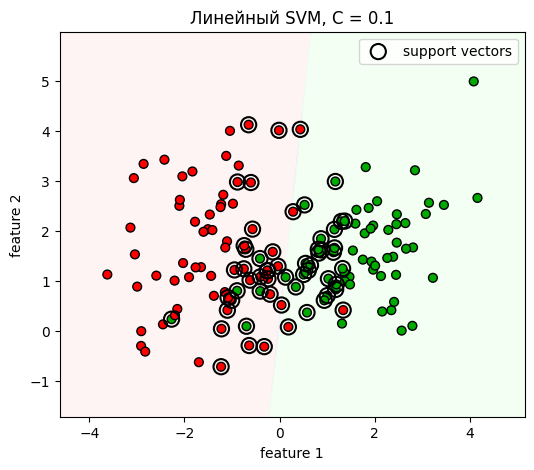

=== C = 1.0 ===
Accuracy train: 0.9285714285714286
Accuracy test: 0.95
Норма вектора w: 2.369460197271623
Количество опорных векторов: 35



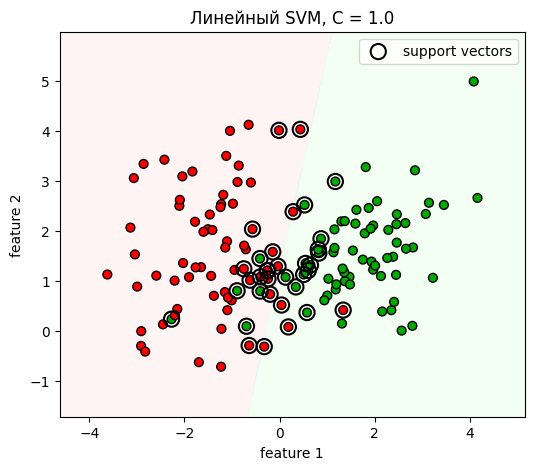

=== C = 10.0 ===
Accuracy train: 0.9428571428571428
Accuracy test: 0.95
Норма вектора w: 2.7538923240241124
Количество опорных векторов: 30



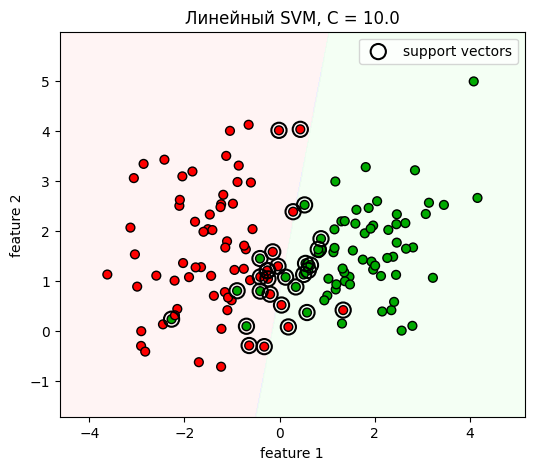

=== C = 100.0 ===
Accuracy train: 0.9428571428571428
Accuracy test: 0.95
Норма вектора w: 3.241054641161344
Количество опорных векторов: 28



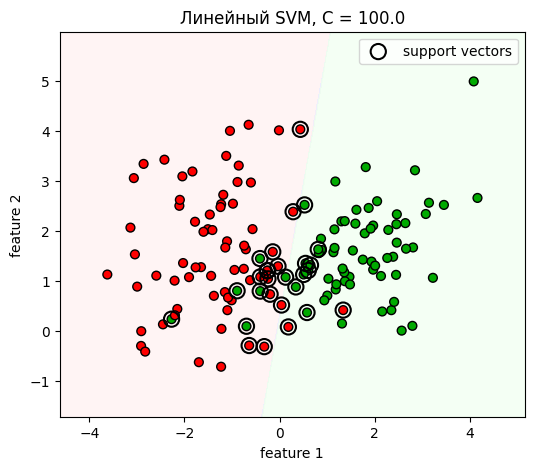

In [5]:
Cs = [0.1, 1.0, 10.0, 100.0]

for C in Cs:
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="linear", C=C))
    ])

    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    svc_step = clf.named_steps["svc"]
    w = svc_step.coef_[0]

    print("=== C =", C, "===")
    print("Accuracy train:", train_acc)
    print("Accuracy test:", test_acc)
    print("Норма вектора w:", np.linalg.norm(w))
    print("Количество опорных векторов:", svc_step.support_vectors_.shape[0])
    print()

    plot_decision_boundary(
        clf, X_train, y_train,
        title=f"Линейный SVM, C = {C}",
        support_vectors=clf.named_steps["scaler"].inverse_transform(svc_step.support_vectors_)
    )

Наблюдения:

- при маленьком $C$ модель сильнее регуляризована: зазор шире, вектор $w$ по норме меньше, допускается больше ошибок;
- при большом $C$ модель стремится минимизировать количество нарушений: вектор $w$ растёт по норме, зазор сжимается, возможно переобучение;
- на тесте качество часто лучше при некоторых промежуточных значениях $C$, а не при максимально большом.

Это дополняет интуицию из теории регуляризации: маленький $C$ соответствует сильному штрафу за $\lVert w \rVert^2$, большой $C$ — слабому.


## 6. Ядровой SVM и kernel trick

До сих пор мы рассматривали только линейные разделяющие гиперплоскости. Если данные **не линейно разделимы** в исходном пространстве признаков, можно поступить двумя способами:

1. Явно построить новые признаки $\phi(x)$ (полиномиальные, RBF и т.п.) и обучить линейный классификатор в пространстве $\phi(x)$.
2. Использовать **ядровые методы**, которые неявно работают в другом пространстве признаков через ядровую функцию.

Идея ядрового метода:

- мы рассматриваем **два объекта** $x$ и $x'$ из исходного пространства признаков (например, два объекта обучающей выборки или объект обучающей выборки и новый объект);
- вместо явного отображения $\phi(x)$ используется функция ядра

$$
K(x, x') = \langle \phi(x), \phi(x') \rangle,
$$

которая возвращает скалярное произведение образов $x$ и $x'$ в новом пространстве.

То есть ядро $K$ принимает **пару объектов** и отвечает числом, соответствующим их "похожести" в скрытом пространстве $\phi$. При этом сами векторы $\phi(x)$ и $\phi(x')$ мы никогда не вычисляем явно.

Типичные ядра:

- линейное ядро:

$$
K(x, x') = x^\top x',
$$

- полиномиальное ядро степени $d$:

$$
K(x, x') = (\gamma x^\top x' + r)^d,
$$

- RBF (Gaussian) ядро:

$$
K(x, x') = \exp(-\gamma \lVert x - x' \rVert^2).
$$

В `scikit-learn` ядровой SVM реализован в классе `SVC` с параметром `kernel`.


### 6.1. Пример: данные, не разделимые линейно

Рассмотрим классический датасет `make_circles`, где классы образуют вложенные окружности.


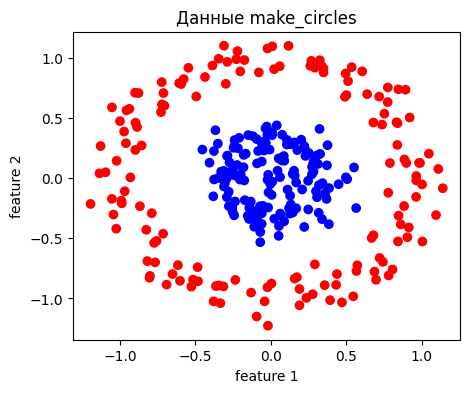

In [6]:
X_circ, y_circ = make_circles(
    n_samples=300,
    noise=0.1,
    factor=0.3,
    random_state=42
)

plt.figure(figsize=(5, 4))
plt.scatter(X_circ[:, 0], X_circ[:, 1], c=y_circ, cmap=ListedColormap(["#FF0000", "#0000FF"]))
plt.title("Данные make_circles")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.show()

C:\Users\Izhan\AppData\Local\Temp\ipykernel_16200\724994040.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


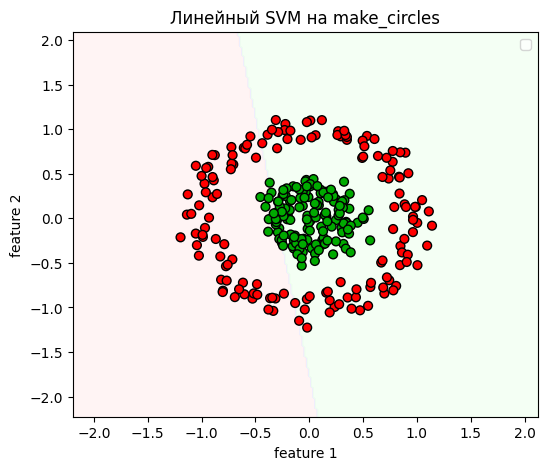

In [7]:
# Линейный SVM на этих данных
linear_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="linear", C=1.0))
])

linear_svm.fit(X_circ, y_circ)

plot_decision_boundary(
    linear_svm, X_circ, y_circ,
    title="Линейный SVM на make_circles"
)

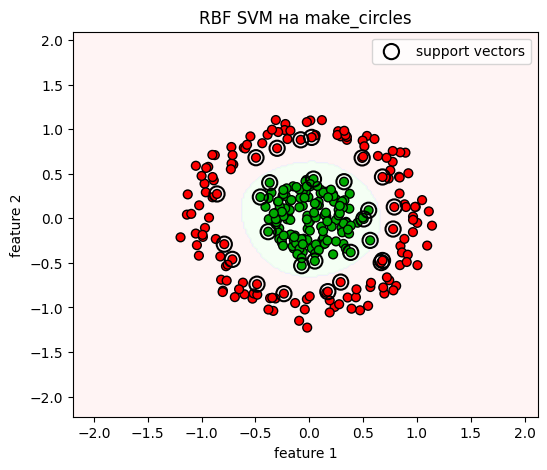

In [8]:
# RBF SVM на тех же данных
rbf_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", C=1.0, gamma=1.0))
])

rbf_svm.fit(X_circ, y_circ)
svc_rbf = rbf_svm.named_steps["svc"]

plot_decision_boundary(
    rbf_svm, X_circ, y_circ,
    title="RBF SVM на make_circles",
    support_vectors=rbf_svm.named_steps["scaler"].inverse_transform(svc_rbf.support_vectors_)
)

На этих картинках видно, что:

- линейный SVM не может разделить вложенные окружности;
- RBF SVM строит нелинейную границу, которая подстраивается под структуру данных;
- опорные векторы отмечены пустыми кружками: именно они определяют положение границы.


### 6.2. Влияние параметра $\gamma$ в RBF-ядре

Параметр $\gamma$ в RBF-ядре управляет тем, насколько локально реагирует модель на отдельные объекты:

$$
K(x, x') = \exp(-\gamma \lVert x - x' \rVert^2).
$$

- при большом $\gamma$ ядро быстро затухает, каждая точка влияет только на очень близких соседей, граница может стать очень извилистой и склонной к переобучению;
- при маленьком $\gamma$ ядро медленно затухает, влияние точек более глобальное, граница становится более гладкой.


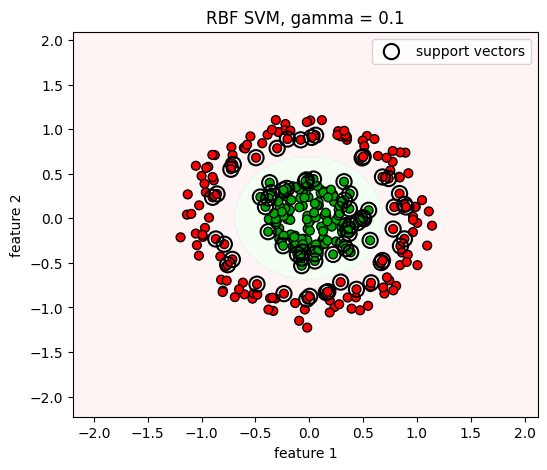

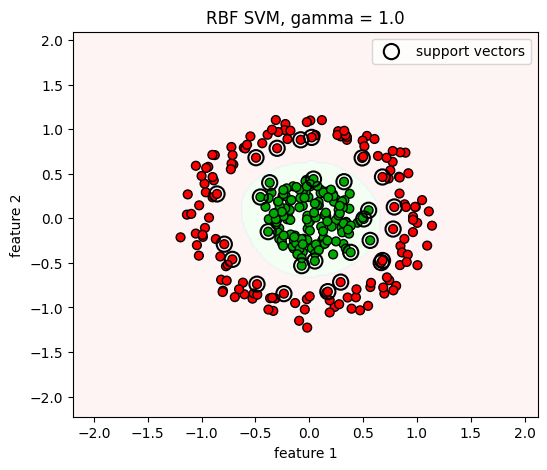

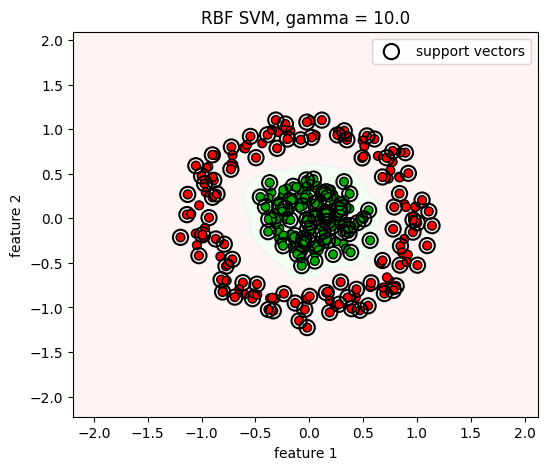

In [9]:
gammas = [0.1, 1.0, 10.0]

for gamma in gammas:
    rbf_svm = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", C=1.0, gamma=gamma))
    ])

    rbf_svm.fit(X_circ, y_circ)
    svc = rbf_svm.named_steps["svc"]

    plot_decision_boundary(
        rbf_svm, X_circ, y_circ,
        title=f"RBF SVM, gamma = {gamma}",
        support_vectors=rbf_svm.named_steps["scaler"].inverse_transform(svc.support_vectors_)
    )

Чем больше $\gamma$, тем более сложной и извилистой становится граница. Совместно с параметром $C$ это даёт широкий спектр возможных решений — и большой потенциал для переобучения при неудачном выборе гиперпараметров.


## 7. `SVC` и `LinearSVC`

В `scikit-learn` есть два часто используемых класса для SVM-классификации:

- `SVC` — реализует ядровой SVM, умеет `kernel="linear"`, `"rbf"`, `"poly"` и т.п.;
- `LinearSVC` — специализирован для линейного SVM, масштабируется лучше по числу объектов и признаков.

Основные различия:

- `SVC(kernel="linear")`:
  - удобен для сравнительно небольших и средних задач;
  - сложность по числу объектов растёт примерно квадратично;
  - поддерживает ядровые версии (при других ядрах).

- `LinearSVC`:
  - рассчитан на большое число объектов и высокоразмерные признаки (например, текстовые TF-IDF);
  - оптимизирует чуть другую функцию (hinge или squared hinge loss);
  - по умолчанию использует схему one-vs-rest в многоклассовом случае.

На практике:

- для задач с очень большим числом признаков (bag-of-words и т.п.) часто используют `LinearSVC`;
- для небольших табличных датасетов можно использовать `SVC` с линейным или RBF-ядром.


### 7.1. Пример многоклассовой классификации

Рассмотрим простую задачу с тремя классами и сравним поведение `LinearSVC` и `SVC(kernel="linear")`.


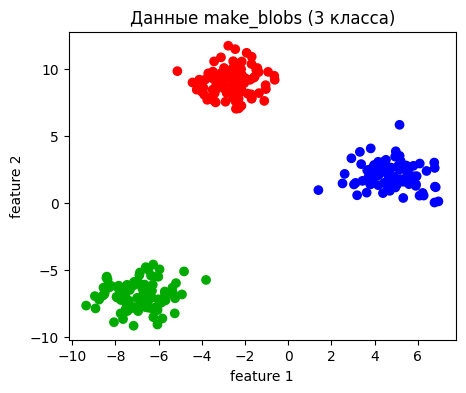

In [10]:
X_blobs, y_blobs = make_blobs(
    n_samples=300,
    centers=3,
    cluster_std=1.0,
    random_state=42
)

plt.figure(figsize=(5, 4))
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs, cmap=ListedColormap(["#FF0000", "#0000FF", "#00AA00"]))
plt.title("Данные make_blobs (3 класса)")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.show()

LinearSVC accuracy: 1.0


C:\Users\Izhan\AppData\Local\Temp\ipykernel_16200\724994040.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


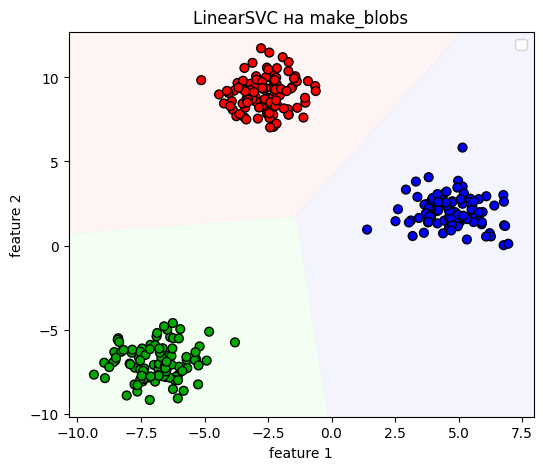

SVC linear accuracy: 1.0


C:\Users\Izhan\AppData\Local\Temp\ipykernel_16200\724994040.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


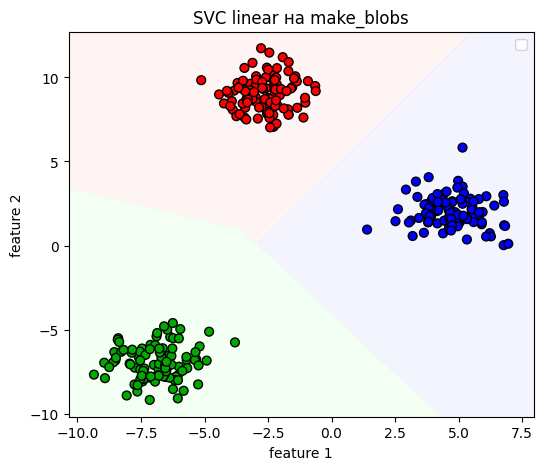

In [11]:
for model_name, model in [
    ("LinearSVC", LinearSVC(C=1.0, max_iter=10000)),
    ("SVC linear", SVC(kernel="linear", C=1.0))
]:
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", model)
    ])

    clf.fit(X_blobs, y_blobs)
    y_pred = clf.predict(X_blobs)
    acc = accuracy_score(y_blobs, y_pred)

    print(model_name, "accuracy:", acc)

    plot_decision_boundary(
        clf, X_blobs, y_blobs,
        title=f"{model_name} на make_blobs"
    )

Обе модели успешно решают задачу и строят линейные границы между классами, хотя внутренние алгоритмы оптимизации у них различаются. В небольших задачах можно использовать любой из этих вариантов.


## 8. Опорные векторы

Ключевая особенность SVM: окончательное решение зависит **не от всех** обучающих объектов, а только от некоторой их части — **опорных векторов**.

Опорные векторы — это те точки, для которых:

- отступ близок к единице (точки, лежащие на границе зазора);
- либо условие $y_i (w^\top x_i + b) \ge 1$ нарушено (ошибочно классифицированные точки или точки внутри зазора).

Именно опорные векторы определяют положение разделяющей гиперплоскости. Если удалить из обучающей выборки все остальные точки, решение SVM почти не изменится.

В `scikit-learn` у `SVC` есть атрибут `support_vectors_`, содержащий координаты опорных векторов.


## 9. Кратко о SVM для регрессии (SVR)

Идея SVM может быть адаптирована и для задач регрессии. В этом случае говорят о **Support Vector Regression (SVR)**.

Основные элементы SVR:

- вместо жёсткого требования точного предсказания вводится $\varepsilon$-инвариантная зона: ошибки меньшие по модулю, чем $\varepsilon$, не штрафуются;
- за отклонения больше $\varepsilon$ вводятся переменные послаблений $\xi_i$ и $\xi_i^*$;
- оптимизируется сумма штрафов за эти отклонения и $L2$-норма весов.

Примально задача (в упрощённой записи) выглядит так:

$$
\min_{w, b, \xi, \xi^*} \; \frac{1}{2} \lVert w \rVert^2 + C \sum_{i=1}^n (\xi_i + \xi_i^*)
$$

при ограничениях

$$
y_i - (w^\top x_i + b) \le \varepsilon + \xi_i,
$$

$$
(w^\top x_i + b) - y_i \le \varepsilon + \xi_i^*,
$$

$$
\xi_i \ge 0, \quad \xi_i^* \ge 0.
$$

В `scikit-learn` SVR реализован в классах `SVR` (ядровой вариант) и `LinearSVR` (линейный вариант). На практике SVR используется реже, чем современные методы регрессии (градиентный бустинг и другие), но полезен для понимания общего семейства SVM.


## 10. Практические рекомендации по применению SVM

1. **Масштабируйте признаки.**  
   SVM (особенно с RBF-ядром) чувствителен к масштабу признаков. Обычно используют стандартизацию (например, `StandardScaler`). Масштабирование удобно включать в `Pipeline`.

2. **Выбор между линейным и ядровым SVM.**  
   - если признаков очень много (тексты, sparse-признаки) и объектов много, часто используют `LinearSVC`;
   - если данные не слишком большие и важно моделировать сложные нелинейные границы, имеет смысл пробовать `SVC` с RBF-ядром.

3. **Сложность по числу объектов.**  
   Ядровой SVM имеет сложность по числу объектов порядка $O(n^2)$ или хуже, поэтому на десятках тысяч объектов и выше он может быть медленным и требовательным к памяти.

4. **Подбор гиперпараметров.**  
   - параметры $C$ и $\gamma$ существенно влияют на качество;
   - обычно подбирают их по сетке на логарифмической шкале (например, $10^{-3}, 10^{-2}, \dots, 10^3$) с использованием кросс-валидации;
   - для более сложных задач разумно использовать `RandomizedSearchCV` или библиотеки вроде `optuna`.

5. **Интерпретация.**  
   - линейный SVM можно интерпретировать через веса $w$ (аналогично логистической регрессии);
   - ядровой SVM менее интерпретируем, так как работает в скрытом пространстве $\phi(x)$.

6. **Сравнение с деревьями и бустингом.**  
   - на табличных данных с большим числом объектов и сложными взаимодействиями признаков часто лучше работают градиентные бустинги (XGBoost, LightGBM, CatBoost);
   - SVM остаётся сильным методом для задач среднего размера с хорошо нормализованными признаками.

7. **Связь с регуляризацией.**  
   - в SVM явно присутствует $L2$-регуляризация через $\frac{1}{2} \lVert w \rVert^2$;
   - параметр $C$ играет роль, обратную силе регуляризации: маленький $C$ — сильная регуляризация, большой $C$ — слабая.
